<a href="https://colab.research.google.com/github/felixzhao/AIML425-ASSN-2/blob/main/P2_12Aug_7_AIML425_Assn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from itertools import product


In [2]:
def plot(data):
    x, y = data[:, 0], data[:, 1]
    # Create a scatter plot of the data
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.2)
    plt.title('2D Gaussian Distribution')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.show()

In [3]:
class FullyConnected(nn.Module):
    def __init__(self, input_dim=2, output_dim=2, hidden_dims=[128, 128], dropout_p=0.5):
        super(FullyConnected, self).__init__()

        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.extend([nn.Linear(prev_dim, dim),
                           nn.ReLU(),
                           nn.Dropout(p=dropout_p)])  # Add dropout after activation
            prev_dim = dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [4]:
num_samples = 1000

# Z will be uniform so you can use the uniform function from torch
Z = torch.rand(num_samples, 2)

# Generate Y
Y = torch.randn(num_samples, 2)

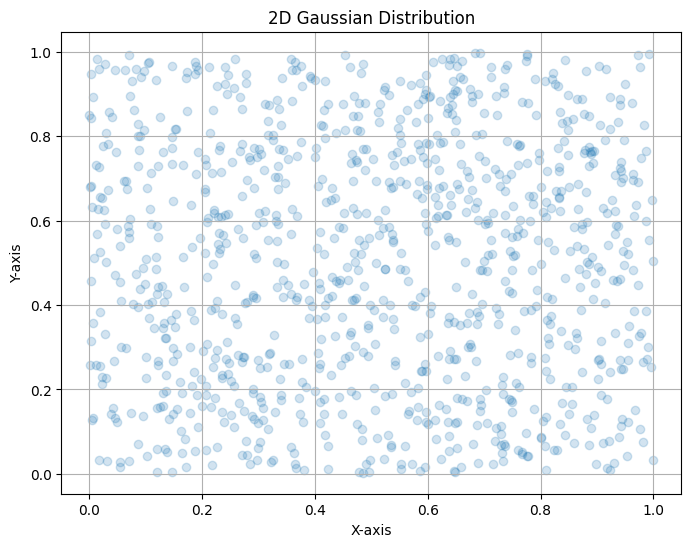

In [5]:
plot(Z)

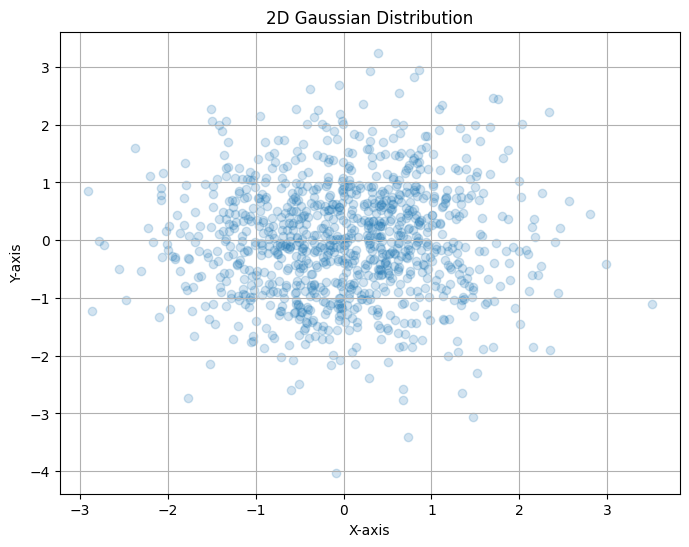

In [6]:
plot(Y)

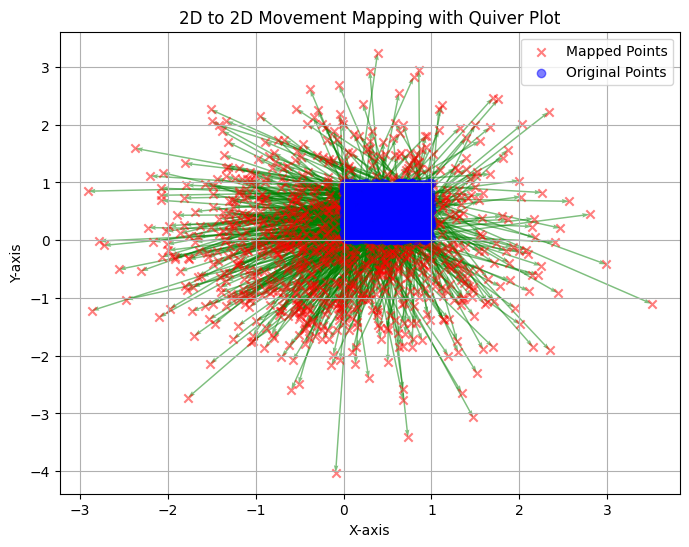

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Sample Data Preparation
original_points = Z
mapped_points = Y

# Calculate displacements
dx = mapped_points[:, 0] - original_points[:, 0]
dy = mapped_points[:, 1] - original_points[:, 1]

# 2. Plotting
plt.figure(figsize=(8, 6))




# Using quiver plot to visualize movements
plt.quiver(original_points[:, 0], original_points[:, 1], dx, dy, angles='xy', scale_units='xy', scale=1, color='green', alpha=0.5)

plt.scatter(mapped_points[:, 0], mapped_points[:, 1], c='red', marker='x', label='Mapped Points', alpha=0.5)

# Scatter plot for original pointsE
plt.scatter(original_points[:, 0], original_points[:, 1], c='blue', label='Original Points', alpha=0.5)

plt.title('2D to 2D Movement Mapping with Quiver Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

plt.grid(True)
plt.show()


In [7]:
batch_sizes = [64, 128, 256, 512]  # example batch sizes, you can choose your own
dataset = TensorDataset(Z, Y)


In [8]:
def compute_mmd(x, y, kernel):
    xx = kernel(x, x)
    yy = kernel(y, y)
    xy = kernel(x, y)
    return xx.mean() + yy.mean() - 2*xy.mean()

def rbf_kernel(x, y, sigma=1.0):
    d = x.unsqueeze(1) - y.unsqueeze(0)
    s = -torch.sum(d**2, dim=2) / (2*sigma**2)
    return torch.exp(s)


In [9]:
def train_model(batch_size, max_epochs, train_dataset, device, dropout_p=0.5):
    model = FullyConnected(dropout_p=dropout_p).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []

    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(max_epochs):
        total_loss = 0.0
        num_batches = 0

        for batch_Z, batch_Y in loader:
            batch_Z, batch_Y = batch_Z.to(device), batch_Y.to(device)

            optimizer.zero_grad()

            outputs = model(batch_Z)
            loss = compute_mmd(outputs, batch_Y, rbf_kernel)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        epoch_avg_loss = total_loss / num_batches
        loss_history.append(epoch_avg_loss)

    return model, epoch_avg_loss, loss_history

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_loss = float('inf')
best_epoch = -1
best_batch_size = -1
best_loss_history = []

for index, batch_size in enumerate(batch_sizes):
    model, epoch_avg_loss, loss_history = train_model(batch_size, 500, dataset, device)

    if epoch_avg_loss < best_loss:
        best_loss = epoch_avg_loss
        best_epoch = index  # Note: This captures the combined batch size and weight_decay index
        best_batch_size = batch_size
        best_model = model.state_dict()
        best_loss_history = loss_history

print(f"Best Model with Batch Size: {best_batch_size}, Loss: {best_loss}")
torch.save(best_model, 'best_model.pth')


Best Model with Batch Size: 512, Loss: 0.004539161920547485


In [11]:
best_model = FullyConnected().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

with torch.no_grad():
    y_pred = best_model(Z.to(device)).cpu()


# Plot

In [12]:
def plot_loss(losses, ax):
    ax.set_title("Training and Validation Loss of Model")
    ax.plot(losses,label="Training")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

def plot_y(y, ax):
    y_np = y.cpu().detach().numpy()

    # Extract x and y coordinates for plotting
    x_coords, y_coords = y_np[:, 0], y_np[:, 1]

    # Plot on the provided axes
    ax.scatter(x_coords, y_coords, s=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)

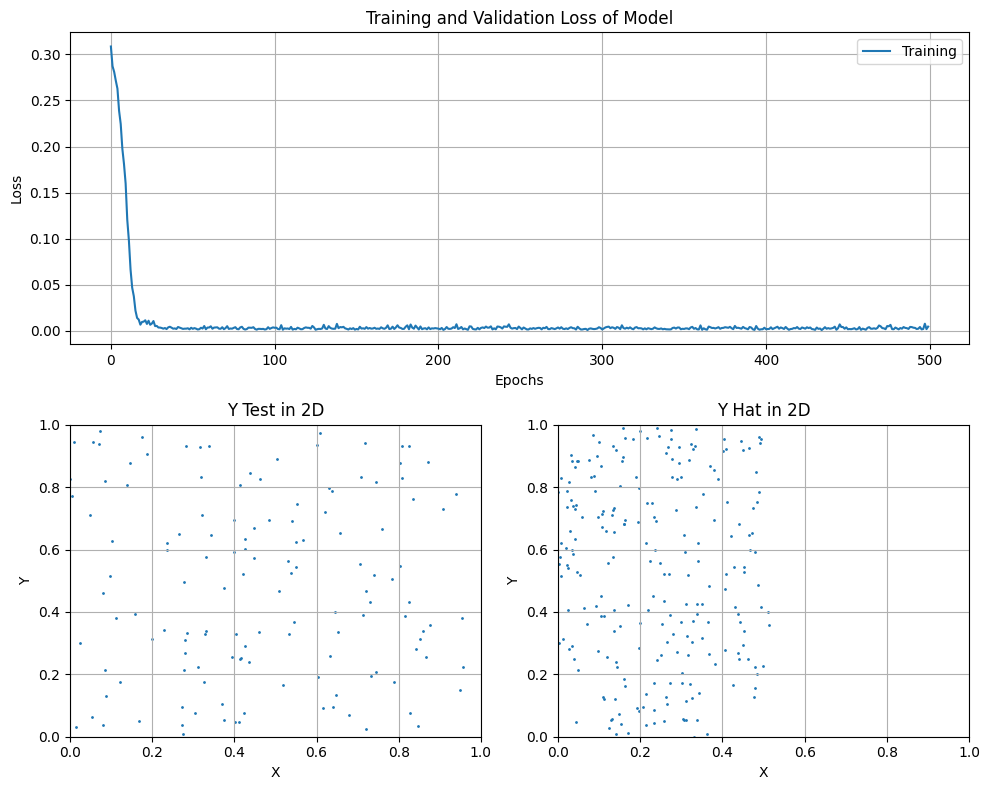

In [13]:
# Create figure
fig = plt.figure(figsize=(10, 8))

# Define the grid layout
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

# Define the axes using the grid layout
ax1 = plt.subplot(gs[0, :])  # This axis spans both columns of the first row
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

# Plot on the defined axes
plot_loss(loss_history, ax1)
plot_y(Y, ax2)
ax2.set_title("Y Test in 2D")
plot_y(y_pred, ax3)
ax3.set_title("Y Hat in 2D")

plt.tight_layout()
plt.show()

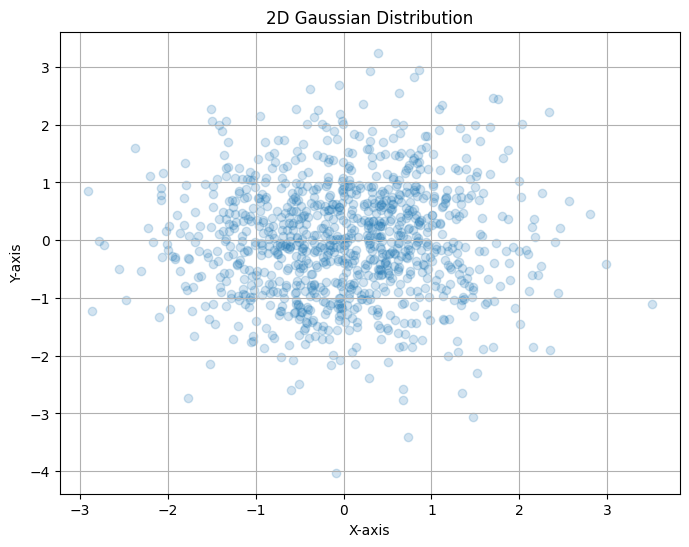

In [14]:
plot(Y)

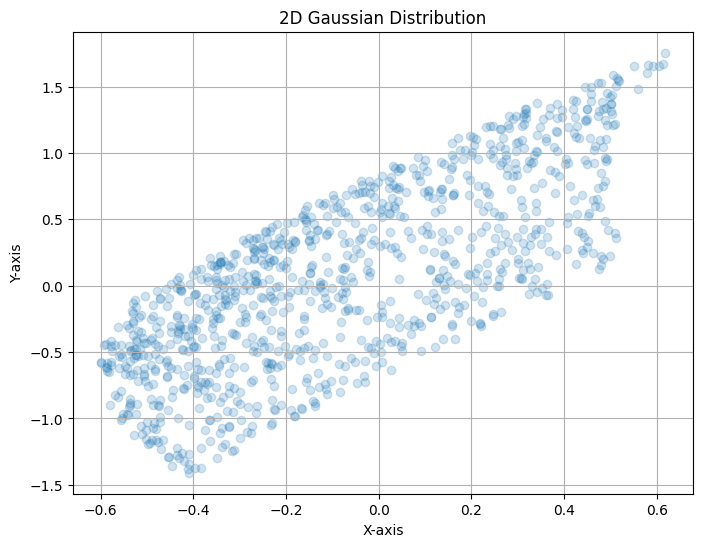

In [15]:
plot(y_pred)

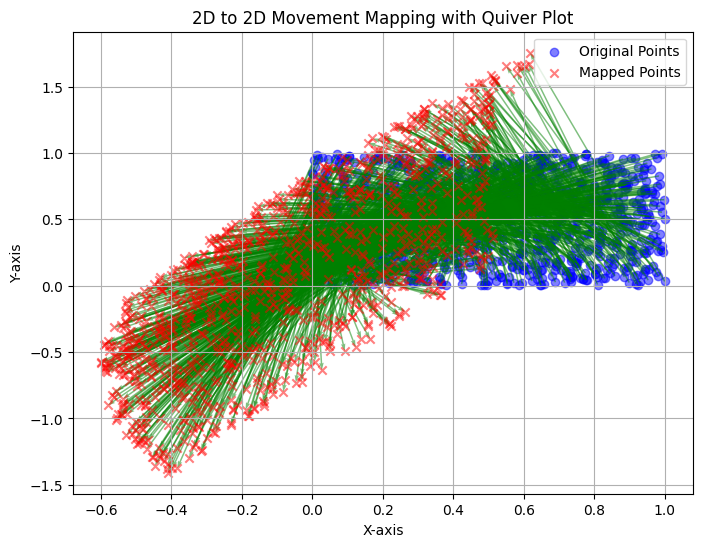

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Sample Data Preparation
original_points = Z
mapped_points = y_pred

# Calculate displacements
dx = mapped_points[:, 0] - original_points[:, 0]
dy = mapped_points[:, 1] - original_points[:, 1]

# 2. Plotting
plt.figure(figsize=(8, 6))

# Scatter plot for original points
plt.scatter(original_points[:, 0], original_points[:, 1], c='blue', label='Original Points', alpha=0.5)


# Using quiver plot to visualize movements
plt.quiver(original_points[:, 0], original_points[:, 1], dx, dy, angles='xy', scale_units='xy', scale=1, color='green', alpha=0.5)

plt.scatter(mapped_points[:, 0], mapped_points[:, 1], c='red', marker='x', label='Mapped Points', alpha=0.5)

plt.title('2D to 2D Movement Mapping with Quiver Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

plt.grid(True)
plt.show()
